In [1]:
from glm.glmnet import ElasticNet, GLMNet
from glm.families import Gaussian, Bernoulli
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
X = np.empty(shape=(100000, 5))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(size=100000)
X[:, 2] = np.random.normal(size=100000)
X[:, 3] = 0.2*X[:, 1] + 0.8*np.random.normal(size=100000)
X[:, 4] = -0.2*X[:, 1] + 0.8*np.random.normal(size=100000)
#X[:, 3] = np.random.normal(size=100000)
#X[:, 4] = np.random.normal(size=100000)

y = 1 + 0.5*X[:, 1] - 0.75*X[:, 2] + X[:, 4] + np.random.normal(scale=0.2, size=100000)

sample_weights = np.random.uniform(size=100000)

In [3]:
#s = StandardScaler()
#X = s.fit_transform(X)
#X[:, 0] = 1.0

In [4]:
enet = ElasticNet(lam=0.0, alpha=0.0)
enet.fit(X, y, sample_weights=sample_weights)

In [5]:
enet.coef_

array([ 1.00040648,  0.50053186, -0.74927003,  0.00163455,  1.00046015])

In [6]:
lr = LinearRegression()
lr.fit(X, y)
lr.coef_

array([ 0.        ,  0.50096038, -0.74976115,  0.00151128,  1.00013386])

In [7]:
lambdas = np.logspace(np.log10(0.000001), np.log10(50))

In [8]:
lambdas

array([  1.00000000e-06,   1.43589220e-06,   2.06178641e-06,
         2.96050303e-06,   4.25096322e-06,   6.10392494e-06,
         8.76457821e-06,   1.25849895e-05,   1.80706883e-05,
         2.59475604e-05,   3.72578996e-05,   5.34983275e-05,
         7.68178313e-05,   1.10302125e-04,   1.58381961e-04,
         2.27419422e-04,   3.26549775e-04,   4.68890276e-04,
         6.73275890e-04,   9.66751600e-04,   1.38815108e-03,
         1.99323532e-03,   2.86207105e-03,   4.10962549e-03,
         5.90097920e-03,   8.47317001e-03,   1.21665587e-02,
         1.74698668e-02,   2.50848455e-02,   3.60191341e-02,
         5.17195937e-02,   7.42637613e-02,   1.06634756e-01,
         1.53116014e-01,   2.19858091e-01,   3.15692518e-01,
         4.53300424e-01,   6.50890544e-01,   9.34608657e-01,
         1.34199728e+00,   1.92696343e+00,   2.76691176e+00,
         3.97298702e+00,   5.70478108e+00,   8.19145067e+00,
         1.17620401e+01,   1.68890217e+01,   2.42508146e+01,
         3.48215555e+01,

In [9]:
enets = []
for lam in lambdas:
    enet = ElasticNet(lam=lam, alpha=0.2)
    enet.fit(X, y)
    enets.append(enet.coef_)

In [10]:
coef_paths = np.row_stack(enets)

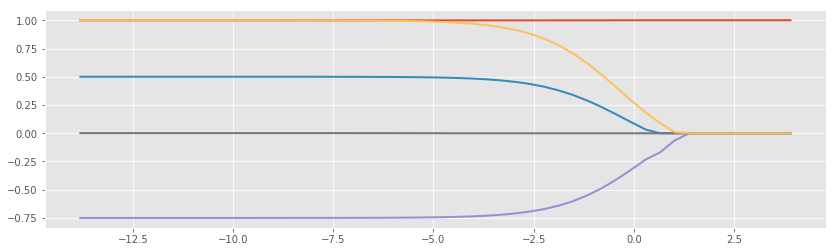

In [11]:
fig, ax = plt.subplots(figsize=(14, 4))

t = np.log(lambdas)
for idx in range(coef_paths.shape[1]):
    ax.plot(t, coef_paths[:, idx])

In [12]:
enet.predict(X)

array([ 1.00129635,  1.00129635,  1.00129635, ...,  1.00129635,
        1.00129635,  1.00129635])

## Coeff Path for Elastic Net

In [13]:
enet = ElasticNet(lam=0.5, alpha=0.2)
enet.fit(X, y)

In [14]:
path = np.row_stack(enet._coef_path)

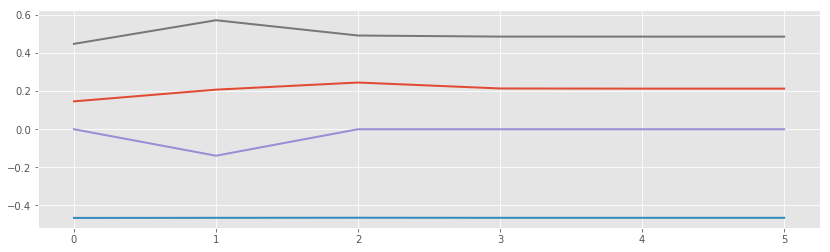

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))

t = np.arange(path.shape[0])
for idx in range(1, path.shape[1]):
    ax.plot(t, path[:, idx])

## GlmNet

In [16]:
X = np.empty(shape=(100000, 5))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(size=100000)
X[:, 2] = np.random.normal(size=100000)
X[:, 3] = 0.25*X[:, 1] + np.sqrt(1 - 0.25**2)*np.random.normal(size=100000)
X[:, 4] = 0.25*X[:, 1] + np.sqrt(1 - 0.25**2)*np.random.normal(size=100000)
#X[:, 3] = np.random.normal(size=100000)
#X[:, 4] = np.random.normal(size=100000)

#y = 1 + 0.05*X[:, 1] + np.random.normal(scale=0.2, size=100000)
y = 1 + 0.5*X[:, 1] - 0.75*X[:, 2] + X[:, 4] + np.random.normal(scale=0.2, size=100000)

s = StandardScaler()
X = s.fit_transform(X)
X[:, 0] = 1.0

sample_weights = np.random.uniform(size=100000)

In [17]:
lambdas = np.logspace(np.log10(0.001), np.log10(10), num=50)
lambdas = lambdas[::-1]

In [18]:
gnet = GLMNet(family=Gaussian(), alpha=0.2, lambdas=lambdas, max_iter=10)
gnet.fit(X, y)

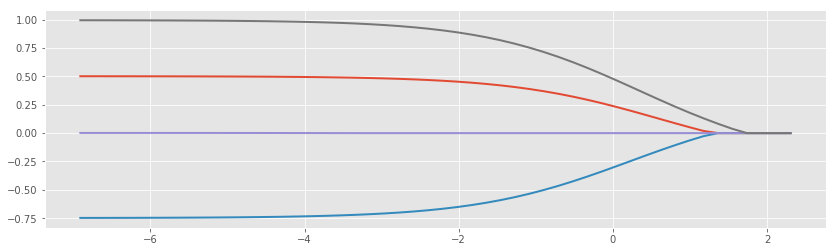

In [19]:
coef_paths = np.row_stack([[g.coef_ for g in enets][-1] for enets in gnet._enets])

fig, ax = plt.subplots(figsize=(14, 4))

t = np.log(lambdas)
for idx in range(1, coef_paths.shape[1]):
     ax.plot(t, coef_paths[:, idx])

In [20]:
lr = LinearRegression()
lr.fit(X, y)
lr.coef_

array([ 0.        ,  0.50106581, -0.74799594,  0.00181141,  0.99780373])

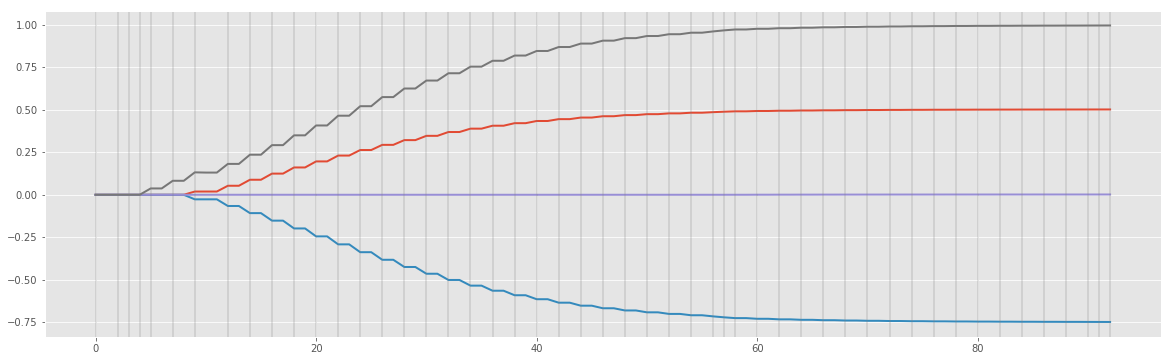

In [21]:
granular_paths = [np.row_stack([g.coef_ for g in enet_list]) for enet_list in gnet._enets]
quad_approx_boundaries = np.cumsum([0] + [path.shape[0] for path in granular_paths])
long_coef_path = np.row_stack(granular_paths)

fig, ax = plt.subplots(figsize=(20, 6))
t = np.arange(long_coef_path.shape[0])
for idx in range(1, long_coef_path.shape[1]):
    ax.plot(t, long_coef_path[:, idx])
    
for boundary in quad_approx_boundaries[:-1]:
    ax.axvline(x=boundary, ymin=0, ymax=1, color="grey", alpha=0.2)

In [22]:
quad_approx_boundaries

array([ 0,  2,  3,  4,  5,  7,  9, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30,
       32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 57, 58, 60, 62,
       64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 91, 92, 93])

In [23]:
long_coef_path.shape[0]

93

## Logit Net

In [24]:
X = np.empty(shape=(100000, 6))
X[:, 0] = 1.0
X[:, 1] = np.random.normal(size=100000)
X[:, 2] = np.random.normal(size=100000)
X[:, 3] = 0.25*X[:, 1] + np.sqrt(1 - 0.25**2)*np.random.normal(size=100000)
X[:, 4] = 0.25*X[:, 1] + np.sqrt(1 - 0.25**2)*np.random.normal(size=100000)
#X[:, 3] = np.random.normal(size=100000)
#X[:, 4] = np.random.normal(size=100000)
X[:, 5] = np.random.normal(size=100000)

lp = 0.05*X[:, 1] - 0.1*X[:, 2] -0.1*X[:, 3] + 0.075*X[:, 5]
p = 1 / (1 + np.exp(-lp))
y = np.random.binomial(1, p=p, size=100000)

In [ ]:
#s = StandardScaler()
#X = s.fit_transform(X)
#X[:, 0] = 1.0

In [ ]:
lambdas = np.logspace(np.log10(0.000001), np.log10(1), num=50)
lambdas = lambdas[::-1]

gnet = GLMNet(family=Bernoulli(), alpha=0.2, lambdas=lambdas)
gnet.fit(X, y)

In [ ]:
coef_paths = np.row_stack([[g.coef_ for g in enets][-1] for enets in gnet._enets])

fig, ax = plt.subplots(figsize=(14, 4))

t = np.log(lambdas)
for idx in range(1, coef_paths.shape[1]):
     ax.plot(t, coef_paths[:, idx])

In [ ]:
granular_paths = [np.row_stack([g.coef_ for g in enet_list]) for enet_list in gnet._enets]
quad_approx_boundaries = np.cumsum([0] + [path.shape[0] for path in granular_paths])
long_coef_path = np.row_stack(granular_paths)

fig, ax = plt.subplots(figsize=(20, 6))
t = np.arange(long_coef_path.shape[0])
for idx in range(1, long_coef_path.shape[1]):
    ax.plot(t, long_coef_path[:, idx])
    
for boundary in quad_approx_boundaries[:-1]:
    ax.axvline(x=boundary, ymin=0, ymax=1, color="grey", alpha=0.2)